# EDA of Elliptic Dataset

In [91]:
# Install necessaries

In [92]:
# Import necessaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import igraph as ig
from tqdm import tqdm

In [93]:
# Plot settings
plot_settings = {'ytick.labelsize': 16,
                        'xtick.labelsize': 16,
                        'font.size': 22,
                        'figure.figsize': (10, 5),
                        'axes.titlesize': 22,
                        'axes.labelsize': 18,
                        'lines.linewidth': 2,
                        'lines.markersize': 3,
                        'legend.fontsize': 11
                }
plt.style.use(plot_settings)

## Loading data

In [94]:
classes_path = "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv"
edges_path = "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv"
feats_path = "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(feats_path, header=None, names=feat_cols)

In [95]:
classes.columns = ['txId', 'label']

In [96]:
df = classes.set_index('txId').join(feats.set_index('txId'))

In [97]:
total = df['time_step'].value_counts().sort_index()
illicit = df['time_step'][df['label']=='1'].value_counts().sort_index()
licit = df['time_step'][df['label']=='2'].value_counts().sort_index()
unknown = df['time_step'][df['label']=='unknown'].value_counts().sort_index()

### An overview of the data
#### Nodes and edges
The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.
#### Features
There are 166 features associated with each node.

Each transaction has a time step, representing the time that the transaction took place. 

- The time steps, running from 1 to 49, are evenly spaced with an interval of about two weeks.

- Each time step contains a single connected component of transactions that appeared on the blockchain within less than three hours between each other; there are no edges connecting the different time steps.

The first 94 features represent local information about the transaction.

The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node

In [98]:
df.head(10)

,label,time_step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
txId,,,,,,,,,,,,,,,,,,,,,
230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
230459870,unknown,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540
230333930,unknown,1,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161887,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
230595899,unknown,1,-0.171755,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163552,...,0.969801,0.704641,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
232013274,unknown,1,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.112635,...,-0.128722,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


## Data Analysis

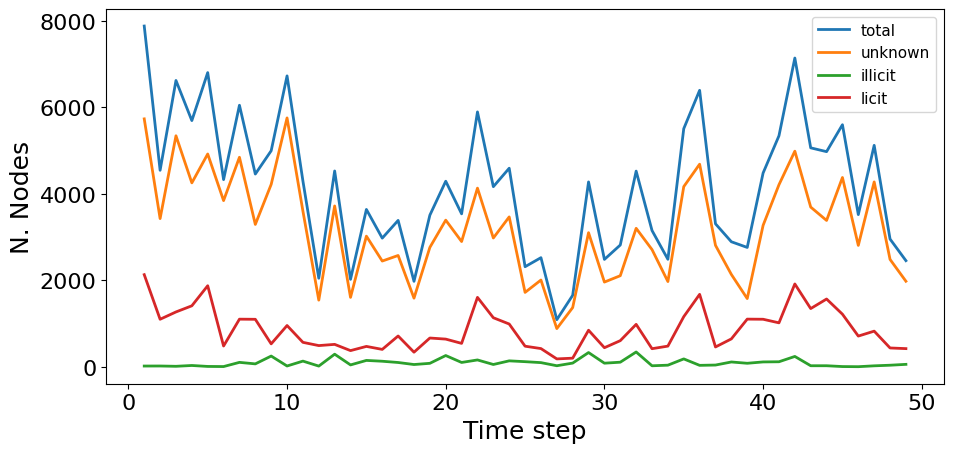

In [99]:
plt.figure(figsize=(10, 5), layout='tight')
step = np.arange(1, 50, dtype=int)
plt.plot(step,total,step,unknown,step,illicit,step,licit)
plt.xlabel('Time step')
plt.ylabel('N. Nodes')
plt.legend(['total', 'unknown', 'illicit', 'licit'])
plt.show()

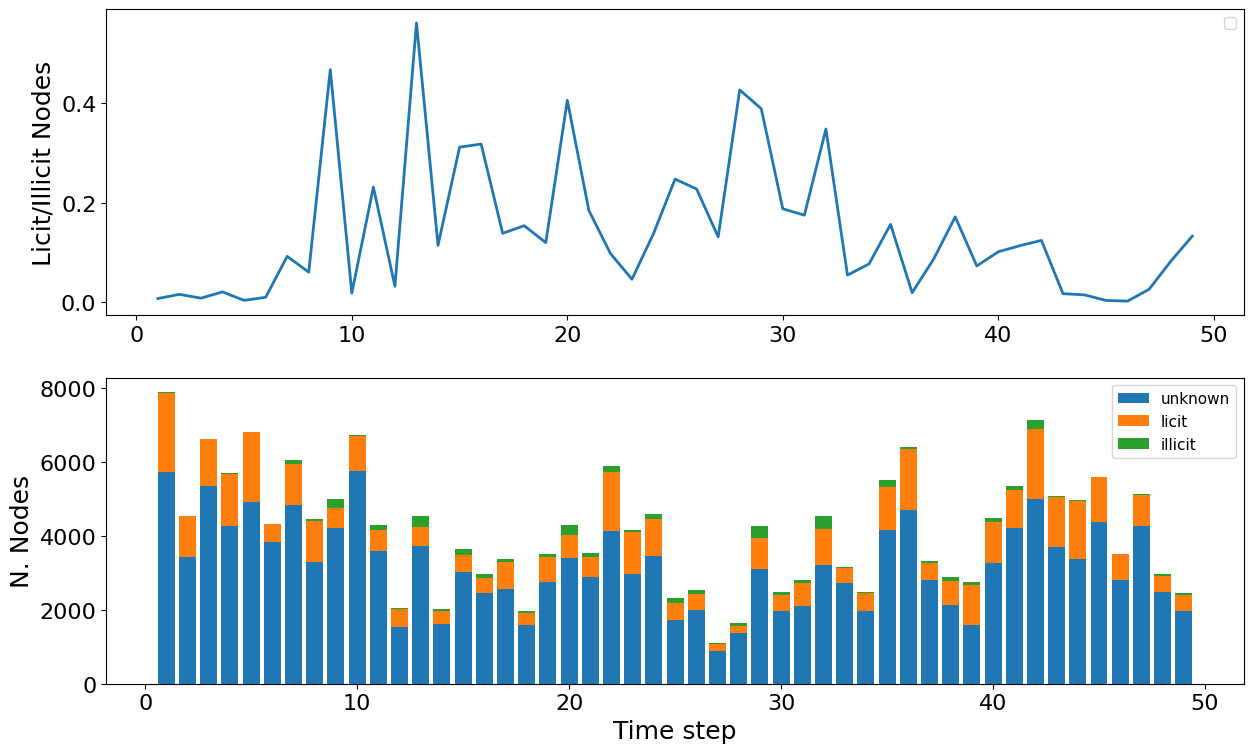

In [100]:
stacked = {
    "unknown":unknown,
    "licit":licit,
    "illicit":illicit  
}
width=0.8
bottom=np.zeros(49)
plt.figure(figsize=(13, 8), layout='tight')
plt.subplot(2, 1, 2)
for label, num in stacked.items():
    plt.bar(step, num, width, label=label, bottom=bottom)
    bottom += num
plt.legend()
plt.xlabel('Time step')
plt.ylabel('N. Nodes')
plt.subplot(2, 1, 1)
plt.plot(step, illicit/licit)
plt.legend()
plt.ylabel('Licit/Illicit Nodes')
plt.show()

### Test on Random Forest Classifier

In [101]:
trans_feat = [f'trans_feat_{i}' for i in range(93)]
agg_feat = [f'agg_feat_{i}' for i in range(72)]
trans_df = df[trans_feat]
agg_df = df[agg_feat]

In [102]:
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    precision_recall_curve, 
    roc_curve,
    confusion_matrix, 
    ConfusionMatrixDisplay
)
def fit_than_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    report = classification_report(y_test, pred)
    cfx = confusion_matrix(y_test, pred)
    return {
        'report': report,
        'cfx': cfx, 
    }

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X = df.drop(columns = agg_feat).drop(columns = ['label'])
df['label'] = LabelEncoder().fit_transform(df['label'])
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# Random Forest on local features only
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier
)
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()

result = fit_than_evaluate(rfc, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.92      0.70      0.80       950
           1       0.93      0.85      0.89      8332
           2       0.95      0.98      0.97     31472

    accuracy                           0.95     40754
   macro avg       0.94      0.84      0.88     40754
weighted avg       0.95      0.95      0.95     40754



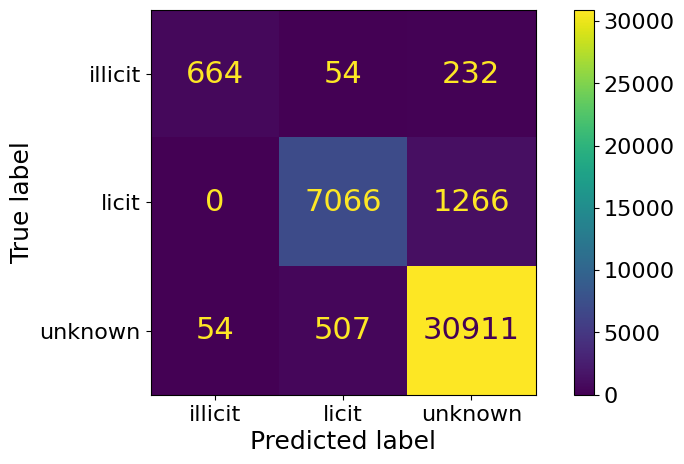

In [106]:
print(result['report'])
disp = ConfusionMatrixDisplay(confusion_matrix=result['cfx'], display_labels=["illicit", "licit", "unknown"])
disp.plot()
plt.show()

From the result above, we can see that the random forest algorithm perform well on this data. Using thi

In [107]:
importances = list(rfc.feature_importances_)
feat_imp = dict()
for i in range(len(importances)):
    feat_imp[X.columns[i]] = importances[i]

most_important_index = np.argmax(importances)
most_important_feature = trans_feat[most_important_index]

print(f"The most important feature is: {most_important_feature}")

The most important feature is: trans_feat_53


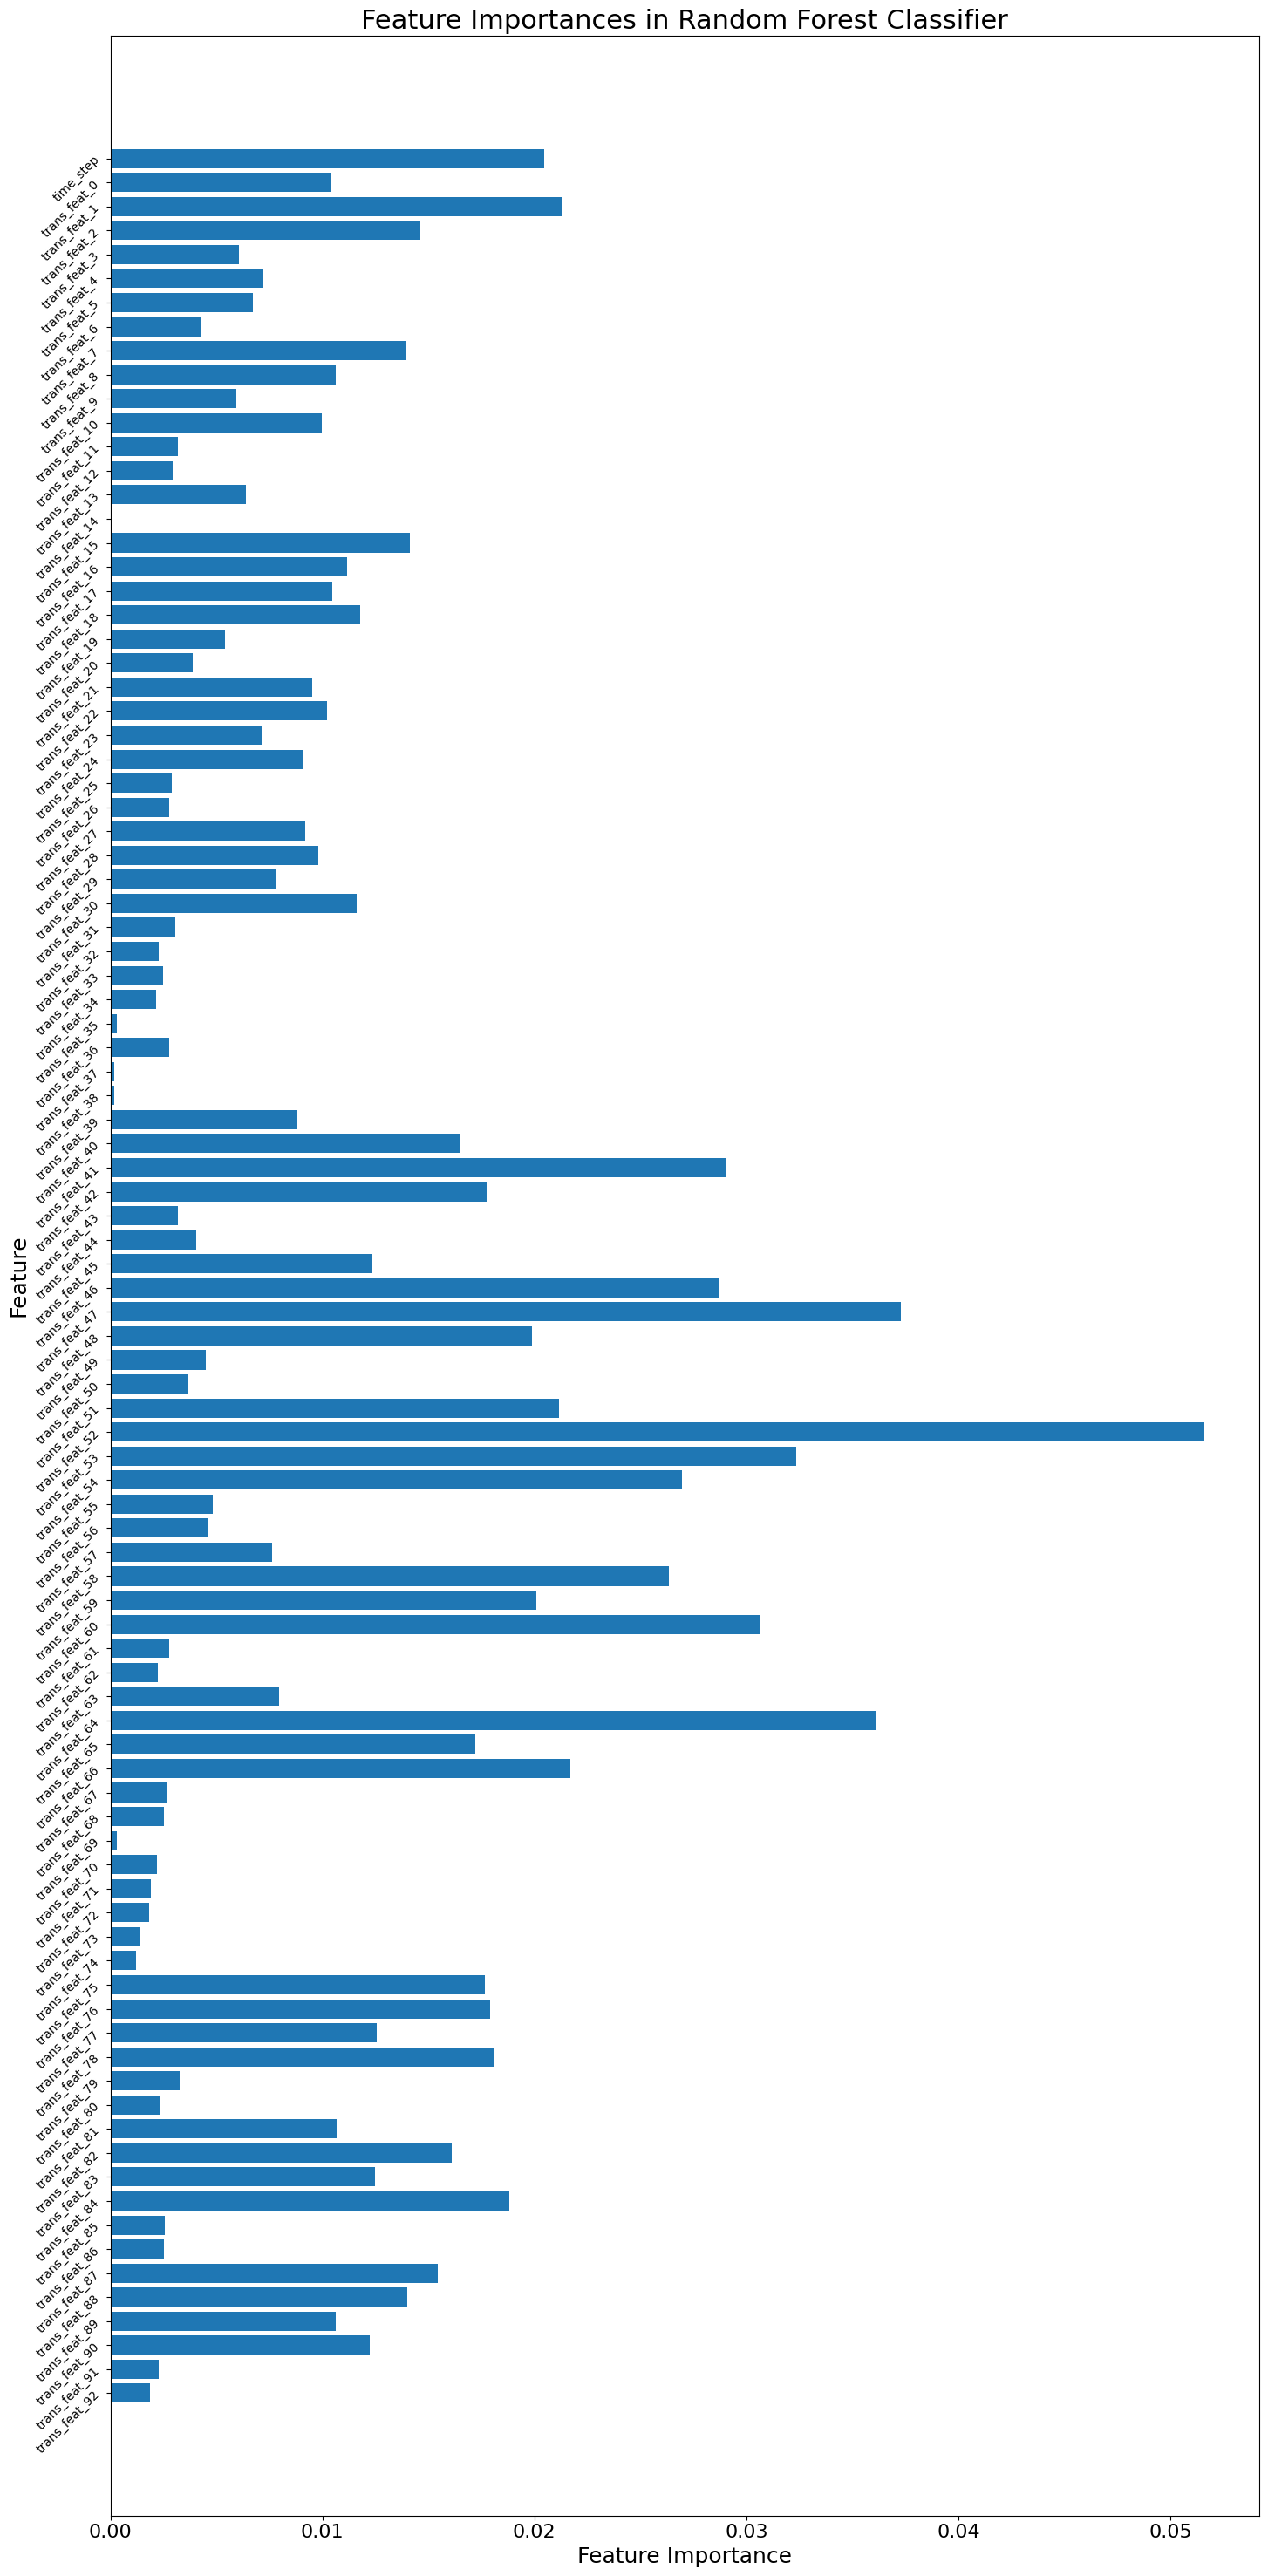

In [108]:
plt.figure(figsize=(15, 30), layout='tight')
plt.barh(range(X.shape[1]), importances, align='center')
plt.yticks(np.arange(X.shape[1]), X.columns, fontsize=10, rotation=45)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Classifier')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()

Some features don't contribute much to prediction.

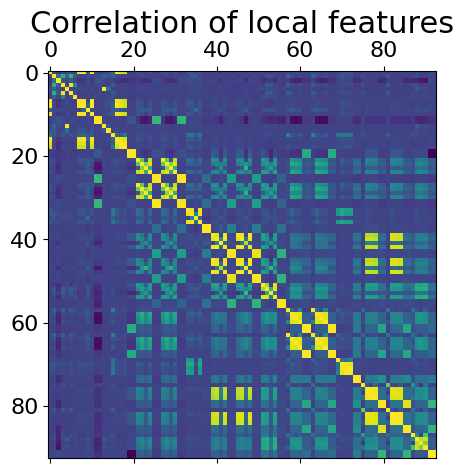

In [133]:
plt.matshow(trans_df.corr())
plt.title("Correlation of local features")
plt.show()

In [111]:
high_corr = []
for i in range(len(trans_feat)):
    for j in range(i+1, len(trans_feat)):
        if(corr[trans_feat[j]][trans_feat[i]]>0.99):
            high_corr.append((i, j))
high_corr

[(0, 8),
 (0, 16),
 (4, 13),
 (7, 10),
 (8, 10),
 (8, 16),
 (19, 20),
 (21, 27),
 (22, 28),
 (23, 29),
 (24, 30),
 (25, 31),
 (26, 32),
 (37, 38),
 (39, 45),
 (45, 48),
 (46, 48),
 (57, 63),
 (58, 64),
 (59, 65),
 (60, 66),
 (61, 62),
 (61, 67),
 (62, 68),
 (67, 68),
 (71, 72),
 (73, 74),
 (79, 80),
 (85, 86),
 (91, 92)]

Some features have high correlation.

In [112]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(agg_df)
# profile.to_widgets()

### Graph structural features

In [113]:
num_tx = len(classes)
num_ed = len(edges)

tx_graph = ig.Graph(num_tx, directed=True)

edges_dict = dict()
for i in range(len(classes)):
    edges_dict[classes.txId[i]] = i
    
colors = {'1':'red', '2':'green', 'unknown':'gray'}

tx_graph.vs['id'] = list(str(i) for i in classes.txId)
tx_graph.vs['type'] = list(classes.label)
tx_graph.vs['time_step'] = list(feats.time_step)
tx_graph.vs['color'] = [colors[i] for i in classes.label]

In [114]:
edges_list = []
for i in tqdm(range(len(edges))):
    src = edges_dict[edges['txId1'][i]]
    dst = edges_dict[edges['txId2'][i]]
    edges_list.append((src, dst))
tx_graph.add_edges(edges_list)

100%|██████████| 234355/234355 [00:03<00:00, 61384.40it/s]


In [117]:
# Some global properties of the graph
diameter = tx_graph.diameter()
radius = tx_graph.radius()
average_path_length = tx_graph.average_path_length()

print(f"Graph diameter: {diameter}")
print(f"Graph radius: {radius}")
print(f"Average path length: {average_path_length}")

Graph diameter: 1248
Graph radius: 0
Average path length: 129.80861706805788


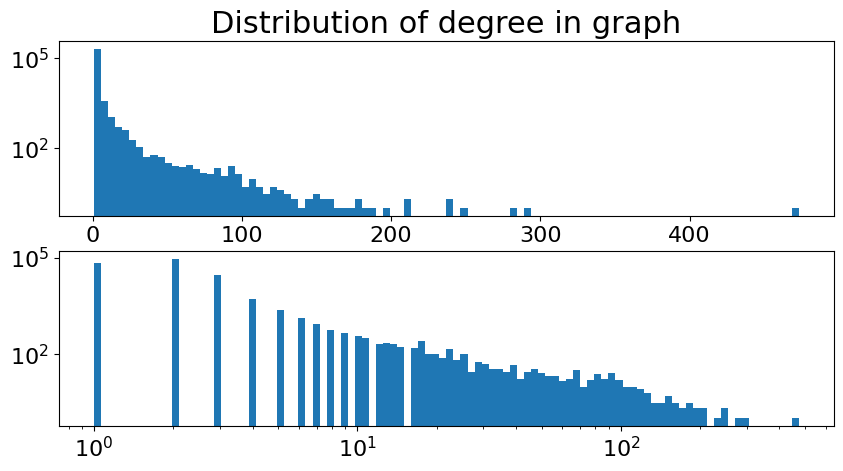

In [118]:
x = pd.Series(tx_graph.degree())

plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=100)
plt.yscale('log')
plt.title("Distribution of degree in graph")

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [119]:
average_degree = x.mean()
max_degree = tx_graph.maxdegree()
print(f"Average degree of vertices: {average_degree}")
print(f"Max degree of vertices: {max_degree}")

Average degree of vertices: 2.3002026804862368
Max degree of vertices: 473


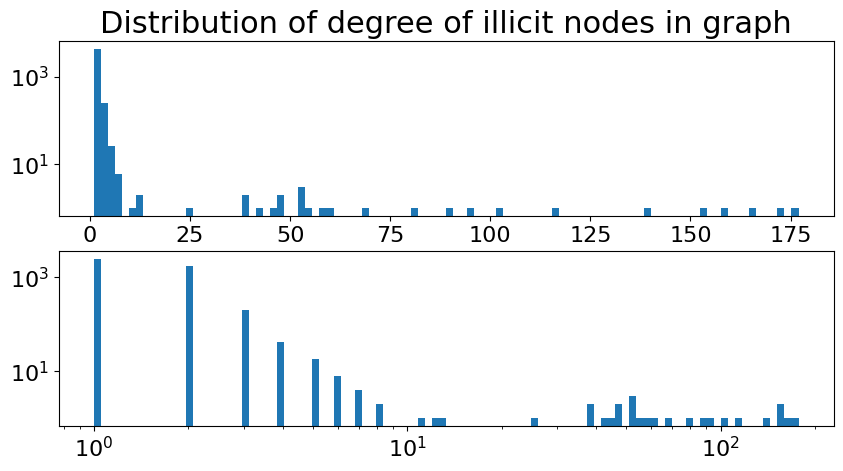

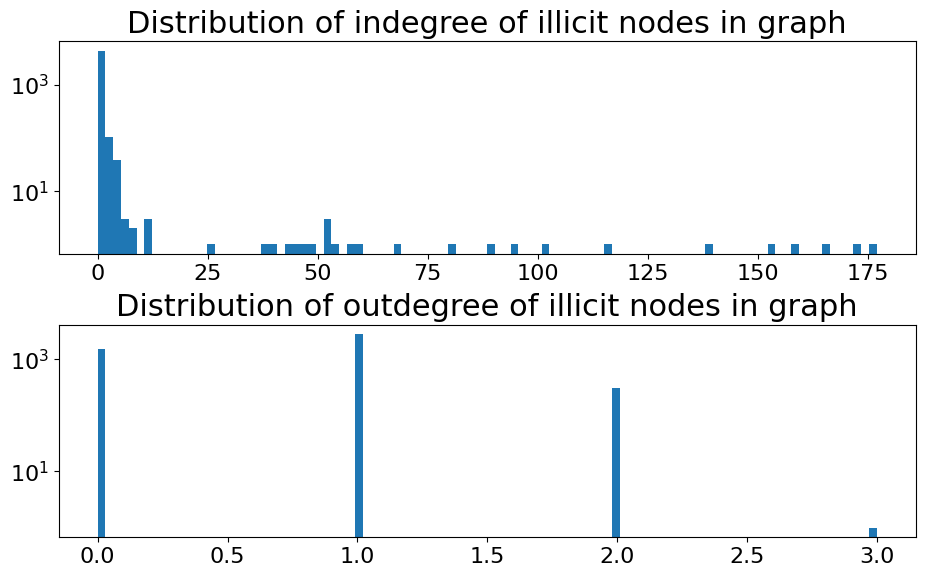

Max degree of a illicit node: 177
Mean degree of a illicit node: 2.0116611661166117


In [120]:
illicit_vertices = list(edges_dict[i] for i in classes['txId'][classes['label']=='1'])
x = tx_graph.degree(illicit_vertices)

plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=100)
plt.yscale('log')
plt.title("Distribution of degree of illicit nodes in graph")

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.show()

in_degree = [tx_graph.vs[i].indegree() for i in illicit_vertices]
out_degree = [tx_graph.vs[i].outdegree() for i in illicit_vertices]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.tight_layout()
plt.subplot(211)
hist, bins, _ = plt.hist(in_degree, bins=100)
plt.yscale('log')
plt.title("Distribution of indegree of illicit nodes in graph")

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
plt.subplot(212)
hist, bins, _ = plt.hist(out_degree, bins=100)
plt.yscale('log')
plt.title("Distribution of outdegree of illicit nodes in graph")
plt.show()

print(f"Max degree of a illicit node: {max(x)}")
print(f"Mean degree of a illicit node: {sum(x)/len(x)}")

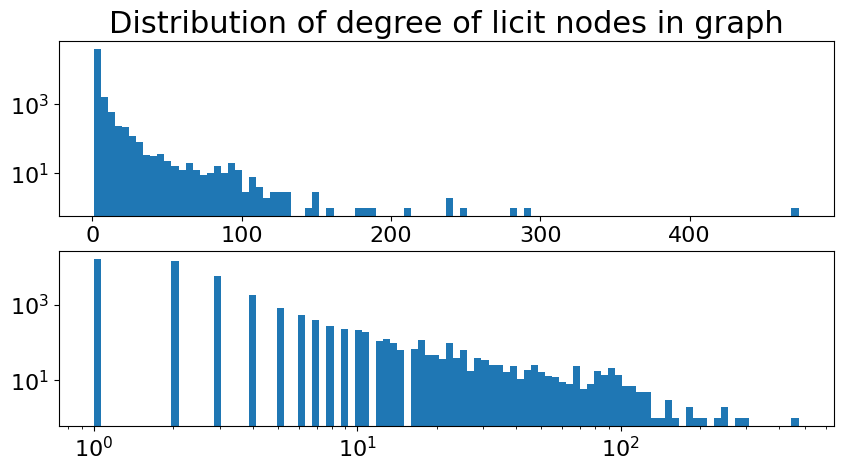

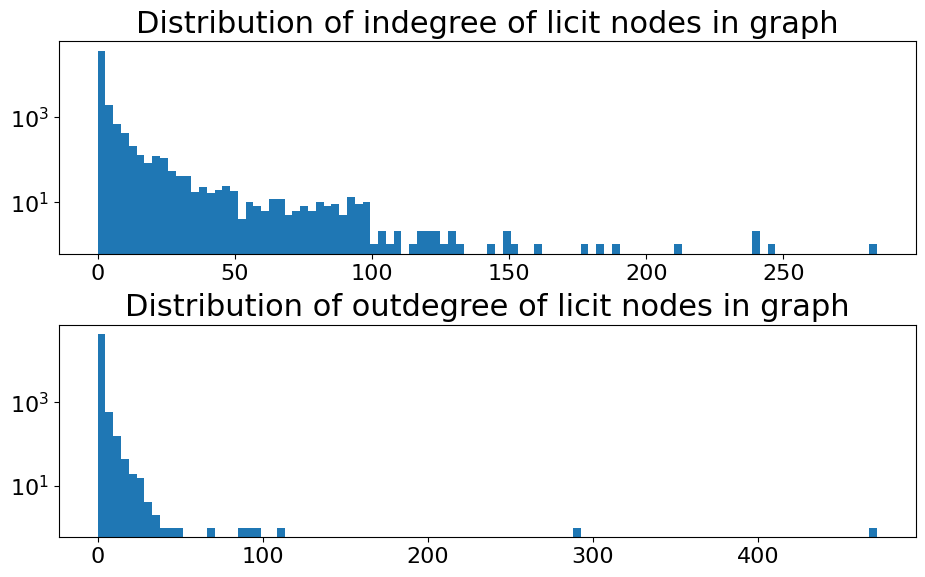

Max degree of a licit node: 473
Mean degree of a licit node: 3.095218829577096


In [121]:
licit_vertices = list(edges_dict[i] for i in classes['txId'][classes['label']=='2'])
x = tx_graph.degree(licit_vertices)

plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=100)
plt.yscale('log')
plt.title("Distribution of degree of licit nodes in graph")

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.show()

in_degree = [tx_graph.vs[i].indegree() for i in licit_vertices]
out_degree = [tx_graph.vs[i].outdegree() for i in licit_vertices]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.tight_layout()
plt.subplot(211)
hist, bins, _ = plt.hist(in_degree, bins=100)
plt.yscale('log')
plt.title("Distribution of indegree of licit nodes in graph")

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
plt.subplot(212)
hist, bins, _ = plt.hist(out_degree, bins=100)
plt.yscale('log')
plt.title("Distribution of outdegree of licit nodes in graph")
plt.show()

print(f"Max degree of a licit node: {max(x)}")
print(f"Mean degree of a licit node: {sum(x)/len(x)}")

In [122]:
tx_graph.is_dag()

True

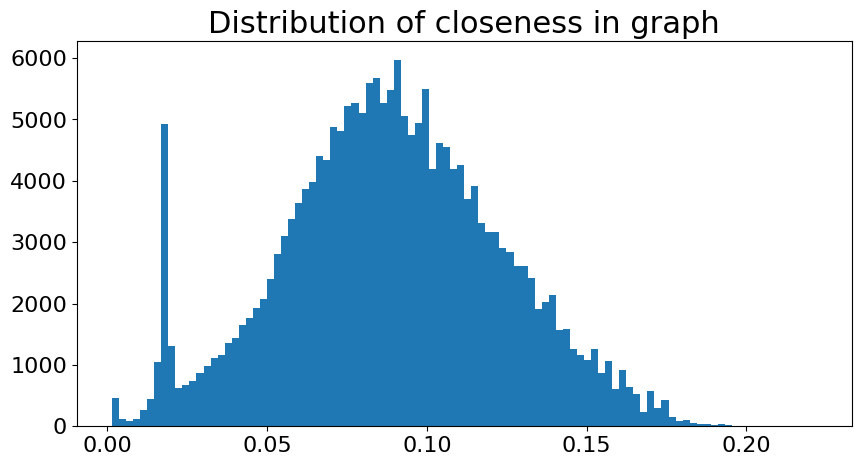

In [123]:
x = pd.Series(tx_graph.closeness())
hist, bins, _ = plt.hist(x, bins=100)
plt.title("Distribution of closeness in graph")
plt.show()

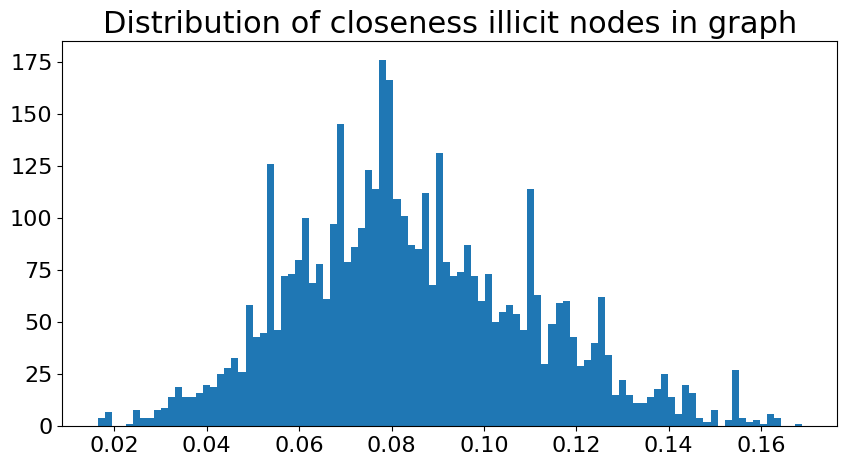

In [124]:
x = tx_graph.closeness(illicit_vertices)
hist, bins, _ = plt.hist(x, bins=100)
plt.title("Distribution of closeness illicit nodes in graph")
plt.show()

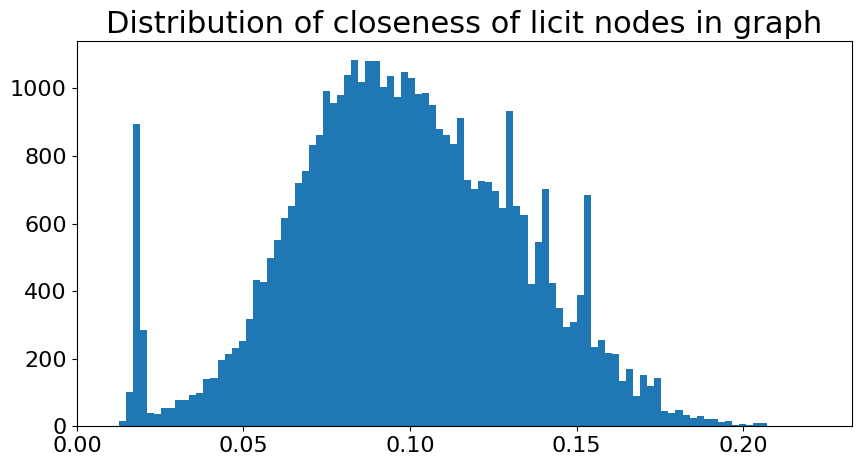

In [125]:
x = tx_graph.closeness(licit_vertices)
hist, bins, _ = plt.hist(x, bins=100)
plt.title("Distribution of closeness of licit nodes in graph")
plt.show()

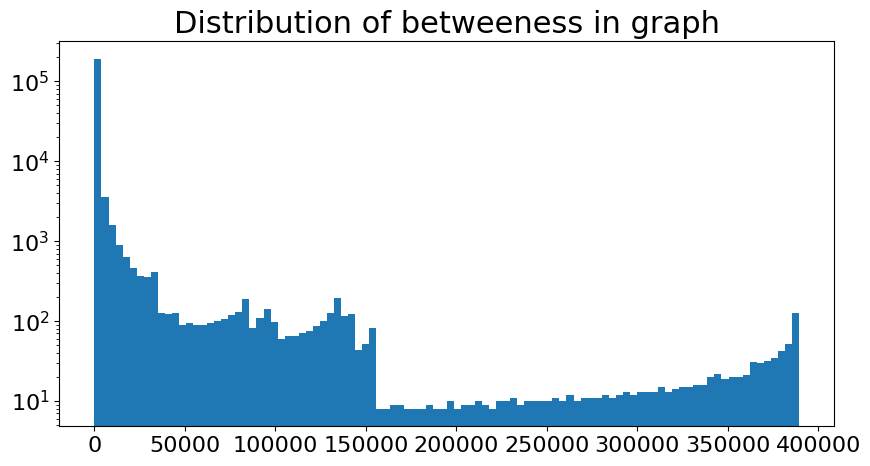

In [126]:
x = pd.Series(tx_graph.betweenness())

hist, bins, _ = plt.hist(x, bins=100)
plt.yscale('log')
plt.title("Distribution of betweeness in graph")
plt.show()

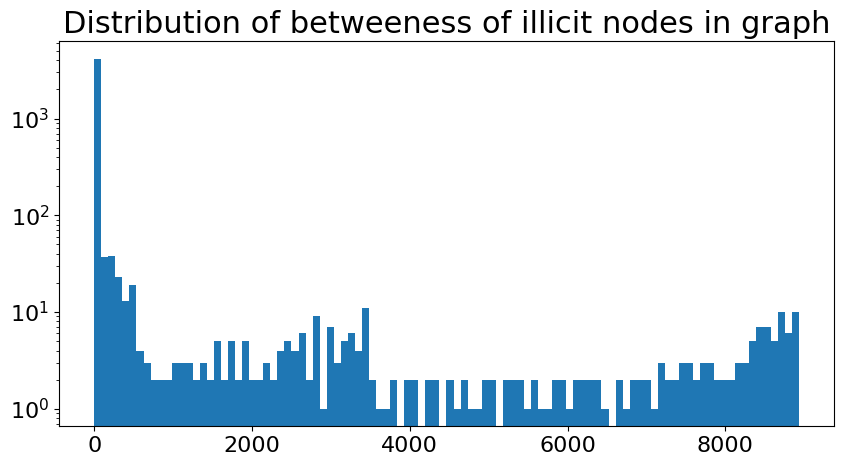

In [127]:
x = pd.Series(tx_graph.betweenness(illicit_vertices))

hist, bins, _ = plt.hist(x, bins=100)
plt.yscale('log')
plt.title("Distribution of betweeness of illicit nodes in graph")
plt.show()

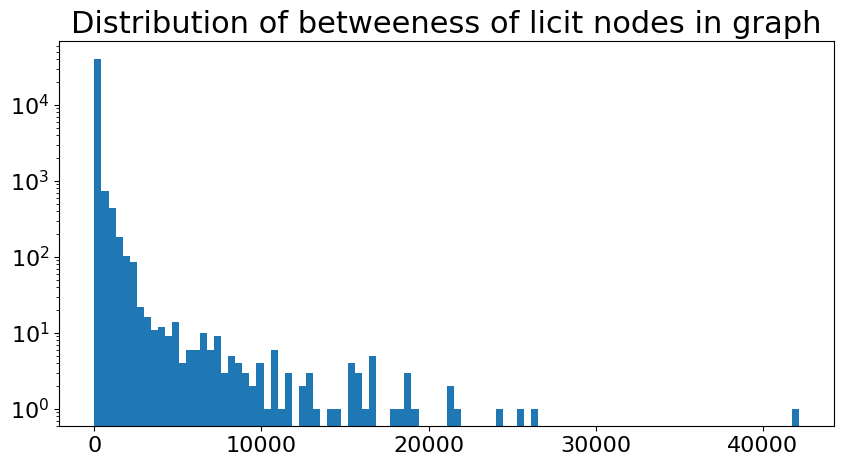

In [128]:
x = pd.Series(tx_graph.betweenness(licit_vertices))

hist, bins, _ = plt.hist(x, bins=100)
plt.yscale('log')
plt.title("Distribution of betweeness of licit nodes in graph")
plt.show()

#### Ploting the graph of a timestep
Because each time step is a connected component. We'll visualise the structure of a specific time step. Here I've chosen time step 28.

In [129]:
subv_list = list(edges_dict[i] for i in df.index[df['time_step']==28])
subgraph = tx_graph.induced_subgraph(subv_list)

In [130]:
layout = subgraph.layout('drl')

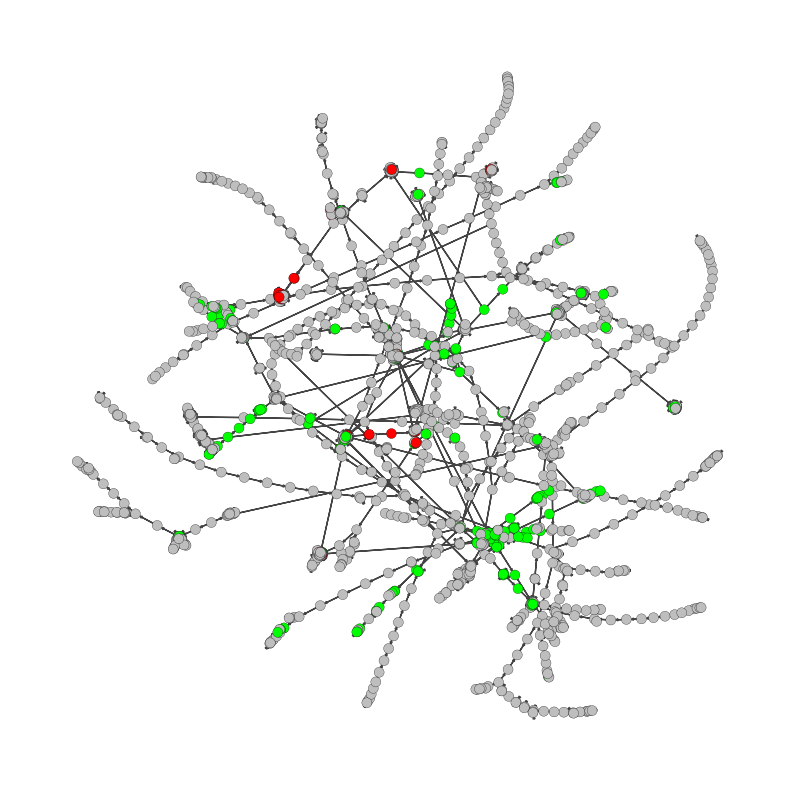

In [131]:
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(subgraph, 
        vertex_size=10, 
        edge_arrow_size=2, 
        edge_arrow_width=2, 
        edge_width=1, 
        target=ax, 
        vertex_frame_width=0.2,
        layout=layout
       )

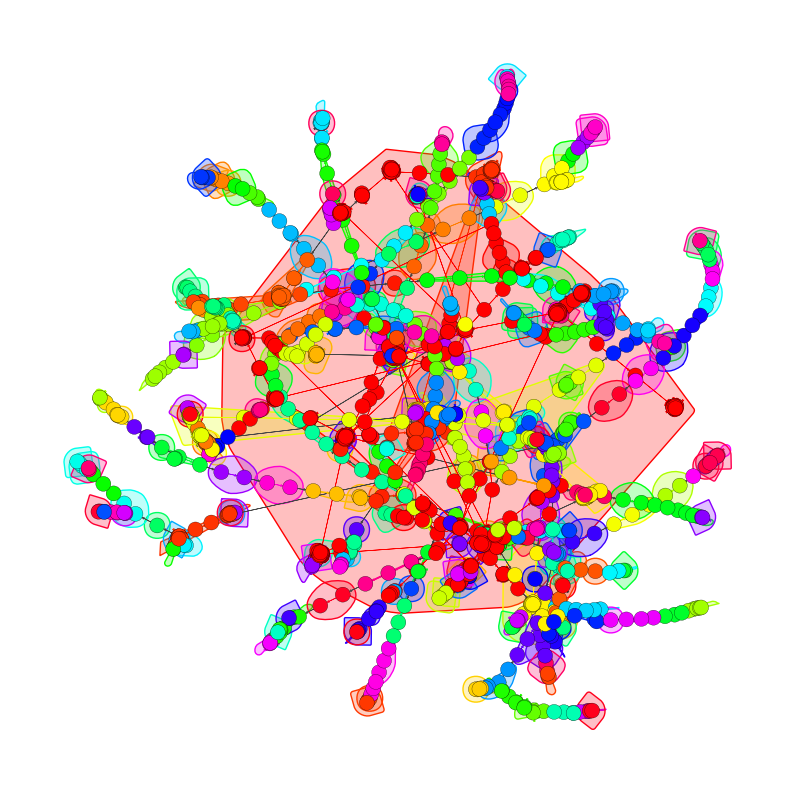

In [134]:
communities = subgraph.community_edge_betweenness()
communities = communities.as_clustering()

num_communities = len(communities)
palette1 = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    subgraph.vs[community]["color"] = i
    community_edges = subgraph.es.select(_within=community)
    community_edges["color"] = i
    
fig1, ax1 = plt.subplots(figsize=(10, 10))
ig.plot(
    communities,
    target=ax1,
    mark_groups=True,
    palette=palette1,
    vertex_size=15,
    edge_width=0.5,
    edge_arrow_size=2,
    edge_arrow_width=2,
    vertex_frame_width=0.2,
    layout=layout
)

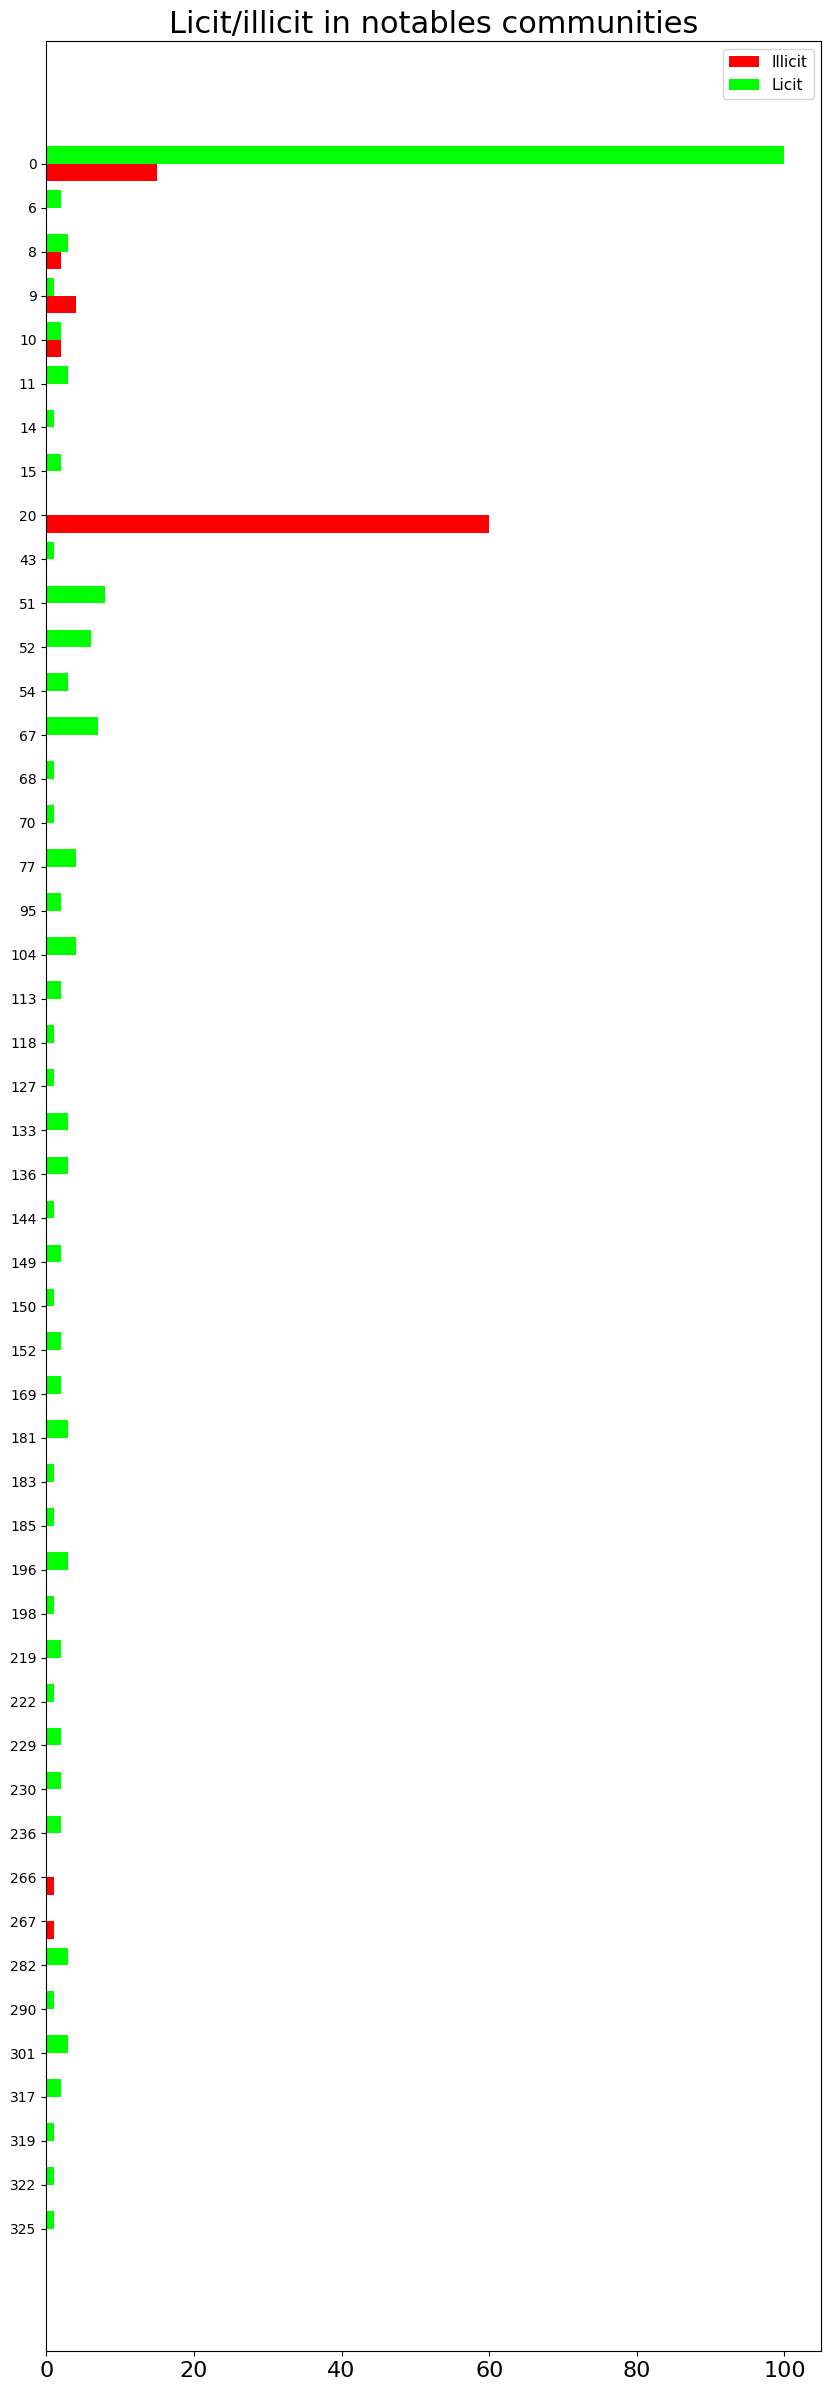

In [135]:
#The percentage of illicit, licit transaction in each cluster
per_community = list()
for i, community in enumerate(communities):
    num_licit = 0
    num_ill = 0
    for v in community:
        if(subgraph.vs[v]['type'] == '1'):
            num_ill += 1
        if(subgraph.vs[v]['type'] == '2'):
            num_licit += 1
    per_community.append([num_ill, num_licit, len(community)-num_ill-num_licit])

labels = []
data = []
for i in range(len(per_community)):
    if(per_community[i][0] != 0) or (per_community[i][1] != 0):
        labels.append(i)
        data.append([per_community[i][0], per_community[i][1]])
data = np.array(data)
fig, ax = plt.subplots(figsize=(10, 30))
width = 0.4 # width of bar
x = np.arange(len(labels))
x = x[::-1]

ax.barh(x - width/2, data[:,0], width, color='#ff0000', label='Illicit')
ax.barh(x + width/2, data[:,1], width, color='#00ff00', label='Licit')

ax.set_yticks(x, labels=[str(i) for i in labels], fontsize=10)
ax.set_title('Licit/illicit in notables communities')
ax.legend()

plt.show()

In [138]:
print(per_community[20])

[60, 0, 14]


The main community 0 contains the majority amount of nodes. Most communities has no licit or illicit nodes. Few communities (besides community 0) have illicit nodes. But one community has a lot of illicit nodes, community 20.

In [ ]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize

def plot_betweenness(g, vertex_betweenness, edge_betweenness, ax, cax1, cax2, layout):
    '''Plot vertex/edge betweenness, with colorbars

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the vertex betweenness colorbar
        cax2: the Axes for the edge betweenness colorbar
    '''

    # Rescale betweenness to be between 0.0 and 1.0
    scaled_vertex_betweenness = ig.rescale(vertex_betweenness, clamp=True)
    scaled_edge_betweenness = ig.rescale(edge_betweenness, clamp=True)
    print(f"vertices: {min(vertex_betweenness)} - {max(vertex_betweenness)}")
    print(f"edges: {min(edge_betweenness)} - {max(edge_betweenness)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("vertex_cmap", ["pink", "indigo"])
    cmap2 = LinearSegmentedColormap.from_list("edge_cmap", ["lightblue", "midnightblue"])

    # Plot graph
    g.vs["color"] = [cmap1(betweenness) for betweenness in scaled_vertex_betweenness]
    g.vs["size"]  = ig.rescale(vertex_betweenness, (5, 30))
    g.es["color"] = [cmap2(betweenness) for betweenness in scaled_edge_betweenness]
    g.es["width"] = ig.rescale(edge_betweenness, (0.5, 1.0))
    ig.plot(
        g,
        target=ax,
        layout=layout,
        vertex_frame_width=0.2,
        edge_arrow_size=3,
        edge_arrow_width=3,
    )

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(vertex_betweenness)), cmap=cmap1)
    norm2 = ScalarMappable(norm=Normalize(0, max(edge_betweenness)), cmap=cmap2)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Vertex Betweenness')
    plt.colorbar(norm2, cax=cax2, orientation="horizontal", label='Edge Betweenness')

In [136]:
betweenness = subgraph.betweenness()
edge_betweenness = subgraph.betweenness()

vertices: 0.0 - 1692.0
edges: 0.0 - 1692.0


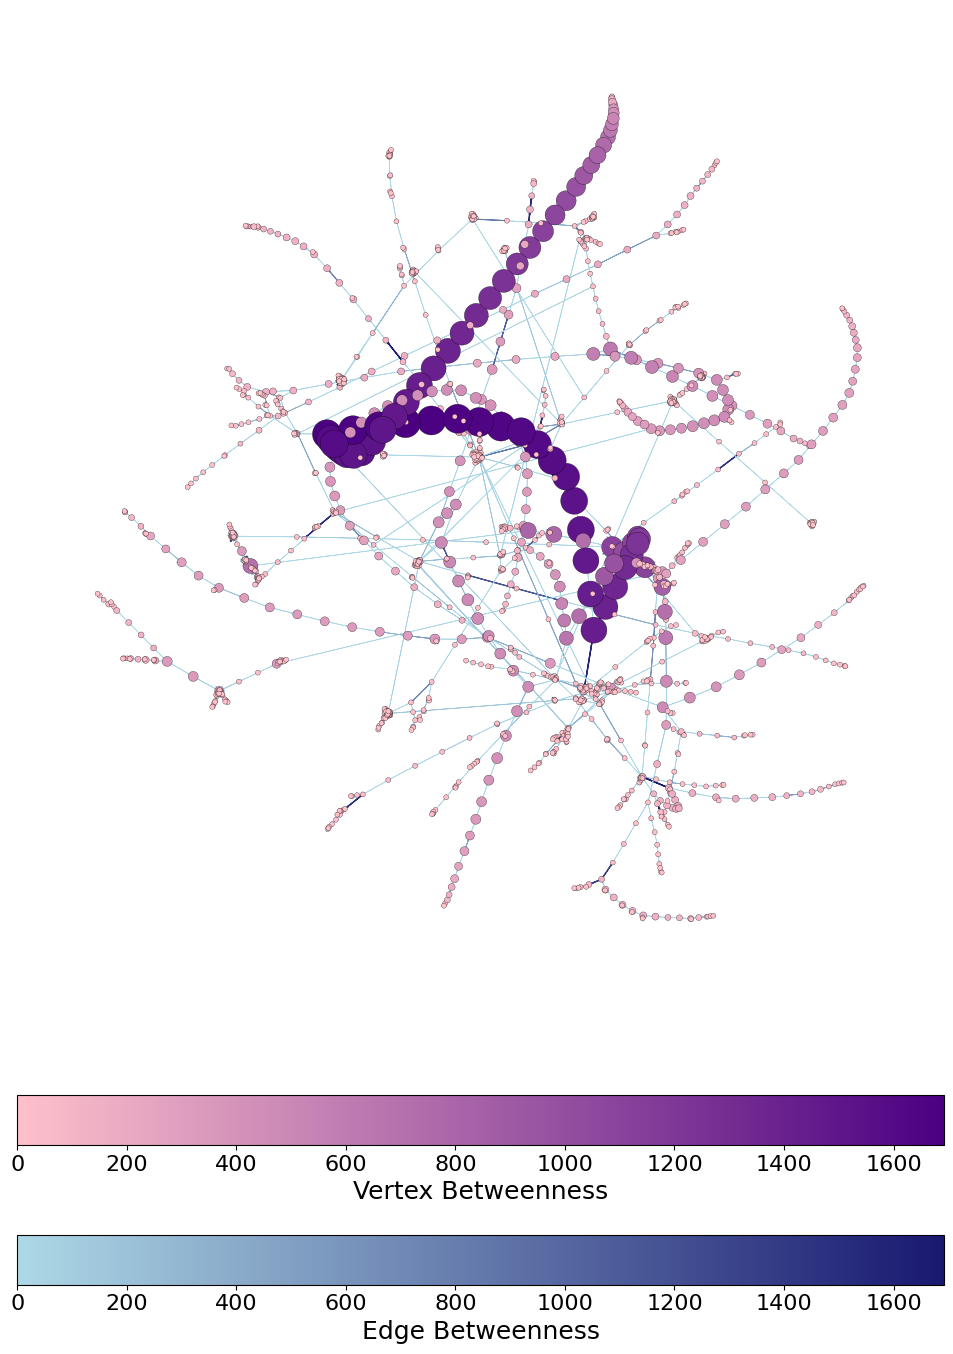

In [137]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 14),
    gridspec_kw={"height_ratios": (20, 1, 1)},
)
plot_betweenness(subgraph, betweenness, edge_betweenness, axs[0], axs[1], axs[2], layout=layout)
fig.tight_layout(h_pad=1)
plt.show()